# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

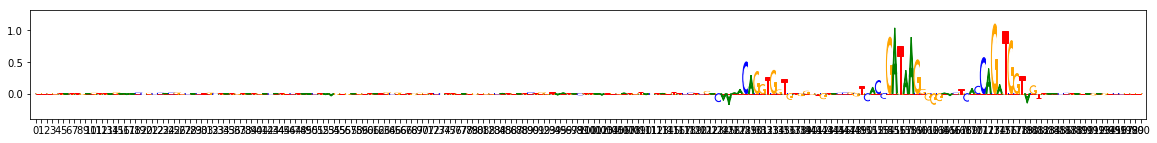

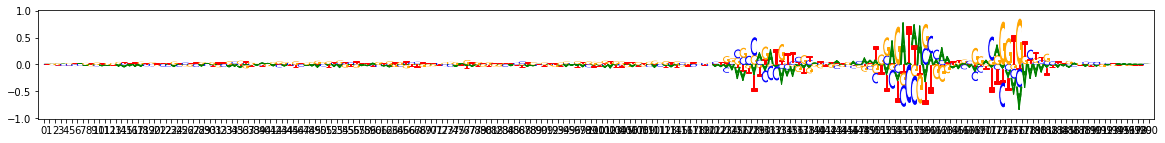

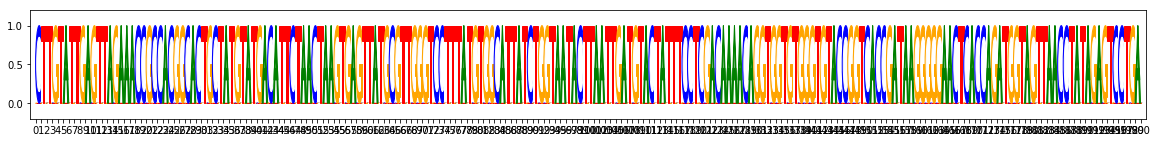

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqelts. For a particular task, "significant" seqlets are identified by fitting a laplace distribution to the left and right tails of the values obtained after smoothing the importance scores with a window of size `sliding_window_size`. This laplace distribution is assumed to represent the null distribution of random seqlet importance scores. A threshold is then identified such that the false discovery rate (computed as the ratio of the expected number of seqlets according to the laplace null to the observed number of seqlets above the threshold) is less that `target_seqlet_fdr`. This is what is meant by "Est. FDR" printed in the logs below. If "Est. FDR" is above the target threshold, that means there was no significant increase in the number of seqlets relative to the null. You'll see below that "Est. FDR" for negative scores for any task is above this threshold, which fits with the simulation because there were no "negative set" motifs.

On task task0
Computing windowed sums
Computing threshold
Thresholds: -1.5073591 and 1.1033133
CDFs: 0.9997648370802383 and 0.9971944838539231
Est. FDRs: 1.0 and 0.00999802820108555


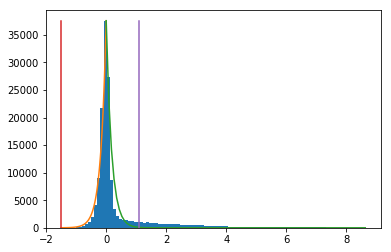

Got 1303 coords
On task task1
Computing windowed sums
Computing threshold
Thresholds: -1.7306354 and 0.75600946
CDFs: 0.9999967851687918 and 0.9978504460291464
Est. FDRs: 0.2506473140761045 and 0.009993533269301972


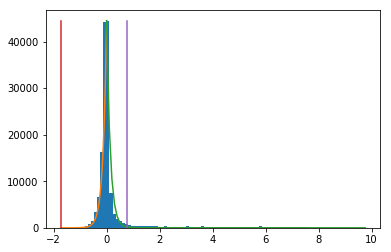

Got 931 coords
On task task2
Computing windowed sums
Computing threshold
Thresholds: -1.6253606 and 0.7336023
CDFs: 0.999998772190054 and 0.9977329655843075
Est. FDRs: 0.09295016289343039 and 0.009975985921105258


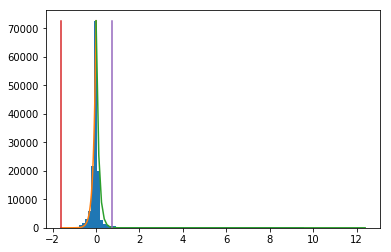

Got 932 coords
After resolving overlaps, got 1767 seqlets
Across all tasks, the weakest laplace threshold used was: 0.9971944838539231
1767 identified in total
4 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [761, 634, 226, 144]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1'}
On metacluster 3
Metacluster size 144
Relevant tasks:  ('task2',)
Relevant signs:  (1,)
(Round 1) num seqlets: 144
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.32 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calcul

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.19853997231 seconds
Wrote graph to binary file in 0.0112981796265 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.722028
Louvain completed 51 runs in 0.605252027512 seconds
Preproc + Louvain took 1.86154818535 s
Got 7 clusters after round 1
Counts:
{0: 36, 1: 28, 2: 23, 3: 15, 4: 11, 5: 8, 6: 8}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 36 seqlets
Trimmed 6 out of 36
Skipped 3 seqlets
Aggregating for cluster 1 with 28 seqlets
Trimmed 4 out of 28
Skipped 1 seqlets
Aggregating for cluster 2 with 23 seqlets
Trimmed 8 out of 23
Skipped 1 seqlets
Aggregating for cluster 3 with 15 seqlets
Trimmed 1 out of 15
Skipped 1 seqlets
Aggregating for cluster 4 with 11 seqlets
Trimmed 1 out of 11
Aggregating for cluster 5 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 6 with 8 seqlets
Trimmed 0 out of 8
Skipped 2 seqlets
(Round 2) num seqlets: 101
(Round 2) Computing coarse affmat
Be

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.28692579269 seconds
Wrote graph to binary file in 0.00591897964478 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.684787
Louvain completed 51 runs in 0.569438934326 seconds
Preproc + Louvain took 1.89613294601 s
Got 7 clusters after round 2
Counts:
{0: 27, 1: 18, 2: 16, 3: 11, 4: 11, 5: 10, 6: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 27 seqlets
Trimmed 0 out of 27
Aggregating for cluster 1 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 2 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 3 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 4 with 11 seqlets
Trimmed 0 out of 11
Skipped 1 seqlets
Aggregating for cluster 5 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 6 with 8 seqlets
Trimmed 0 out of 8
Got 7 clusters
Splitting into subclusters...
Merging on 7 clusters
On merging iteration 1
Computing pattern to seqlet distances
Com

[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.2s finished


Job completed in: 0.66 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.69 s
(Round 2) Computed affinity matrix on nearest neighbors in 1.43 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 0.217562
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0120248794556 seconds
Running Louvain modularity optimization


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.24253296852 seconds
Wrote graph to binary file in 0.0156621932983 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.715153
Louvain completed 51 runs in 0.598320007324 seconds
Preproc + Louvain took 1.89814901352 s
Got 9 clusters after round 2
Counts:
{0: 23, 1: 23, 2: 22, 3: 22, 4: 20, 5: 17, 6: 5, 7: 4, 8: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 1 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 2 with 22 seqlets
Trimmed 0 out of 22
Aggregating for cluster 3 with 22 seqlets
Trimmed 0 out of 22
Aggregating for cluster 4 with 20 seqlets
Trimmed 0 out of 20
Skipped 2 seqlets
Aggregating for cluster 5 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 6 with 5 seqlets
Trimmed 0 out of 5
Aggregating for cluster 7 with 4 seqlets
Trimmed 0 out of 4
Aggregating for cluster 8 with 2 seqlets
Trimmed 0 out of 2


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 1.98994612694 seconds
Wrote graph to binary file in 0.147892951965 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.69042
After 3 runs, maximum modularity is Q = 0.690555
After 15 runs, maximum modularity is Q = 0.692633
After 23 runs, maximum modularity is Q = 0.692851
After 51 runs, maximum modularity is Q = 0.698756
Louvain completed 101 runs in 1.97081518173 seconds
Preproc + Louvain took 4.21380591393 s
Got 9 clusters after round 1
Counts:
{0: 125, 1: 114, 2: 104, 3: 94, 4: 41, 5: 38, 6: 25, 7: 12, 8: 12}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 125 seqlets
Trimmed 4 out of 125
Skipped 4 seqlets
Aggregating for cluster 1 with 114 seqlets
Trimmed 8 out of 114
Skipped 8 seqlets
Aggregating for cluster 2 with 104 seqlets
Trimmed 7 out of 104
Skipped 3 seqlets
Aggregating for cluster 3 with 94 seqlets
Trimmed 5 out of 94
Skipped 6 seqlets
Aggregating for cluster 4 with 41 seqlets

[Parallel(n_jobs=20)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 1.93030905724 seconds
Wrote graph to binary file in 0.125811100006 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.632837
After 2 runs, maximum modularity is Q = 0.639306
After 5 runs, maximum modularity is Q = 0.640768
After 37 runs, maximum modularity is Q = 0.641563
After 65 runs, maximum modularity is Q = 0.643623
After 93 runs, maximum modularity is Q = 0.647023
After 129 runs, maximum modularity is Q = 0.647511
Louvain completed 179 runs in 3.28336215019 seconds
Preproc + Louvain took 5.45248985291 s
Got 11 clusters after round 2
Counts:
{0: 74, 1: 69, 2: 62, 3: 53, 4: 48, 5: 47, 6: 45, 7: 35, 8: 34, 9: 29, 10: 13}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 74 seqlets
Trimmed 0 out of 74
Aggregating for cluster 1 with 69 seqlets
Trimmed 4 out of 69
Aggregating for cluster 2 with 62 seqlets
Trimmed 4 out of 62
Aggregating for cluster 3 with 53 seqlets
Trimmed 3 out of 53
Aggre

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.8s finished


Louvain completed 200 runs in 2.5195581913 seconds
Wrote graph to binary file in 0.317176103592 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.681666
After 2 runs, maximum modularity is Q = 0.681714
After 6 runs, maximum modularity is Q = 0.681849
Louvain completed 56 runs in 1.67803001404 seconds
Preproc + Louvain took 4.68601584435 s
Got 7 clusters after round 1
Counts:
{0: 148, 1: 130, 2: 128, 3: 112, 4: 99, 5: 63, 6: 28}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 148 seqlets
Trimmed 5 out of 148
Skipped 11 seqlets
Aggregating for cluster 1 with 130 seqlets
Trimmed 0 out of 130
Skipped 12 seqlets
Aggregating for cluster 2 with 128 seqlets
Trimmed 13 out of 128
Skipped 6 seqlets
Aggregating for cluster 3 with 112 seqlets
Trimmed 4 out of 112
Skipped 6 seqlets
Aggregating for cluster 4 with 99 seqlets
Trimmed 2 out of 99
Skipped 6 seqlets
Aggregating for cluster 5 with 63 seqlets
Trimmed 0 out of 63
Skipped 6

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.9s finished


Louvain completed 200 runs in 2.6203930378 seconds
Wrote graph to binary file in 0.244951963425 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.655793
After 3 runs, maximum modularity is Q = 0.655991
After 4 runs, maximum modularity is Q = 0.658124
Louvain completed 54 runs in 1.44581794739 seconds
Preproc + Louvain took 4.47491908073 s
Got 7 clusters after round 2
Counts:
{0: 156, 1: 140, 2: 118, 3: 95, 4: 55, 5: 48, 6: 19}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 156 seqlets
Trimmed 0 out of 156
Aggregating for cluster 1 with 140 seqlets
Trimmed 0 out of 140
Aggregating for cluster 2 with 118 seqlets
Trimmed 0 out of 118
Aggregating for cluster 3 with 95 seqlets
Trimmed 6 out of 95
Aggregating for cluster 4 with 55 seqlets
Trimmed 1 out of 55
Aggregating for cluster 5 with 48 seqlets
Trimmed 5 out of 48
Aggregating for cluster 6 with 19 seqlets
Trimmed 1 out of 19
Got 7 clusters
Splitting into subclusters..

In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.01,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

## Save and print the results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


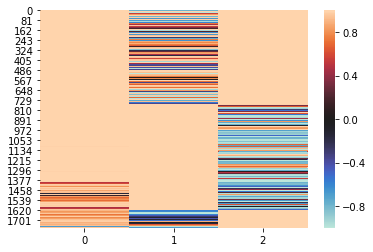

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 592
Task 0 hypothetical scores:


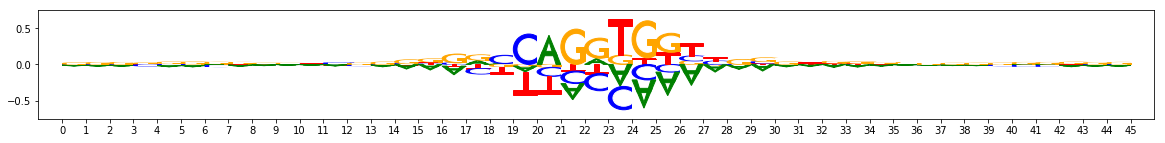

Task 0 actual importance scores:


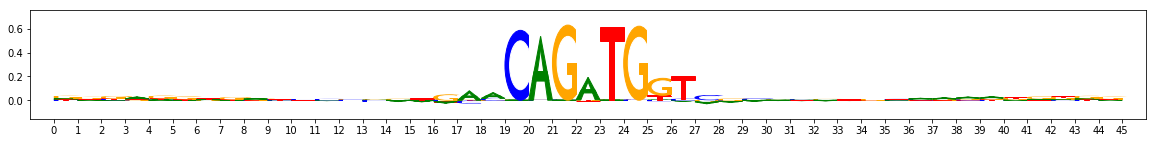

Task 1 hypothetical scores:


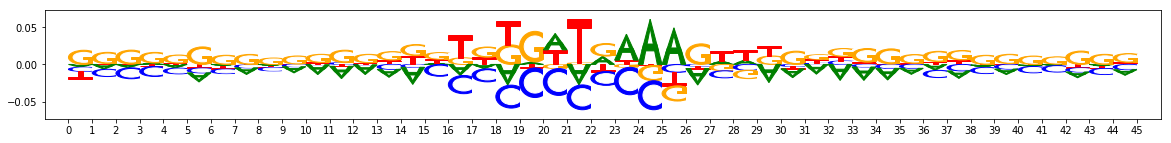

Task 1 actual importance scores:


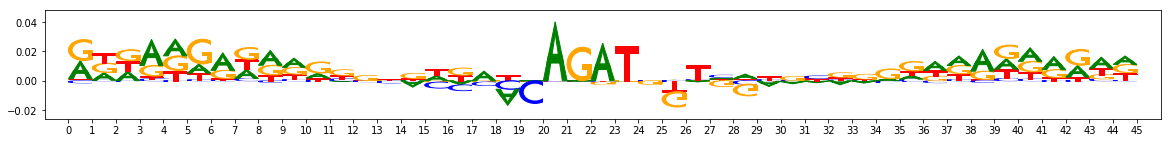

Task 2 hypothetical scores:


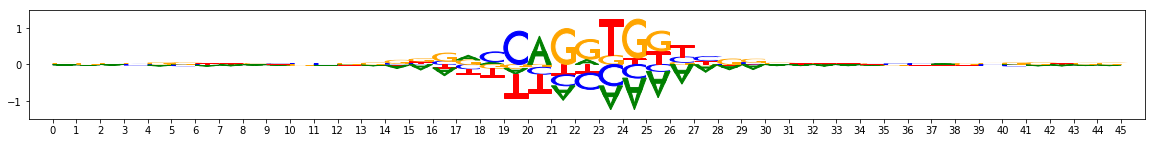

Task 2 actual importance scores:


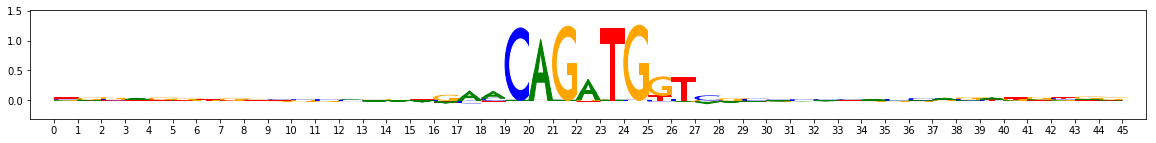

onehot, fwd and rev:


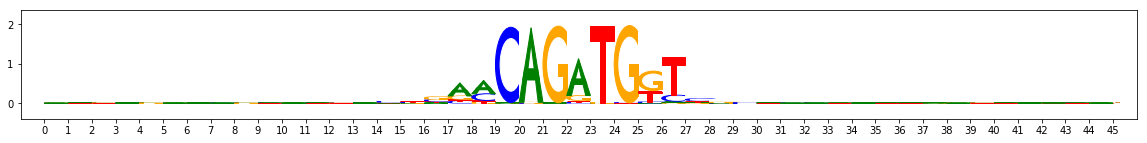

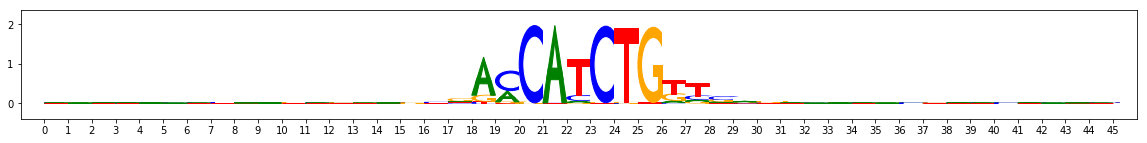

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 467
Task 0 hypothetical scores:


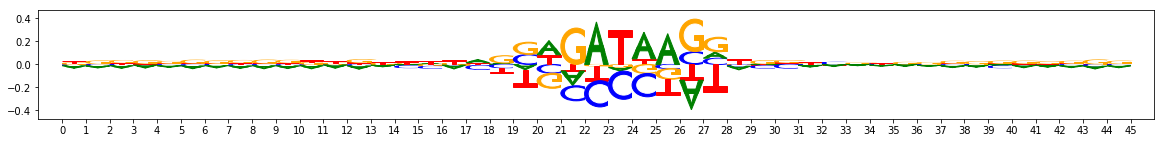

Task 0 actual importance scores:


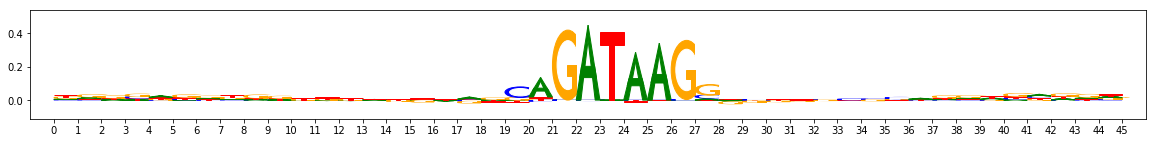

Task 1 hypothetical scores:


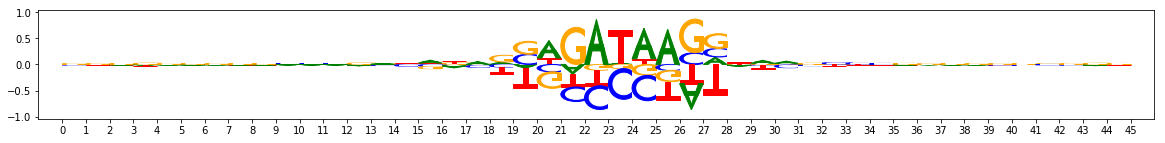

Task 1 actual importance scores:


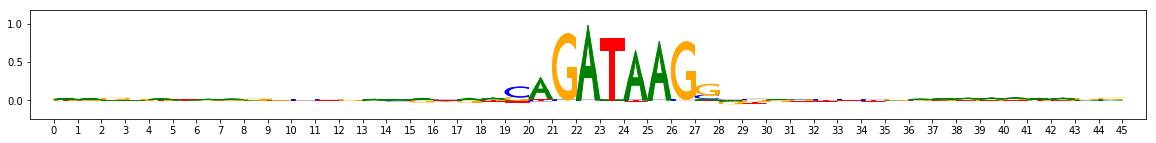

Task 2 hypothetical scores:


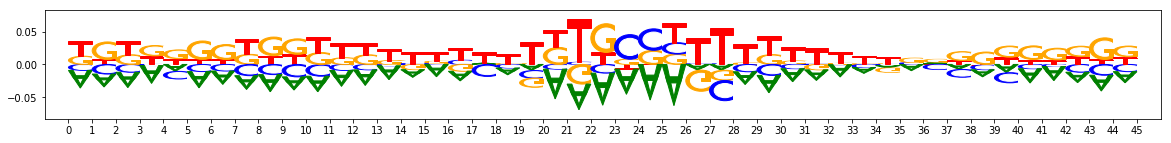

Task 2 actual importance scores:


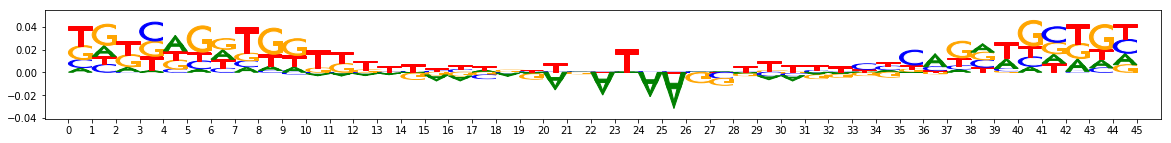

onehot, fwd and rev:


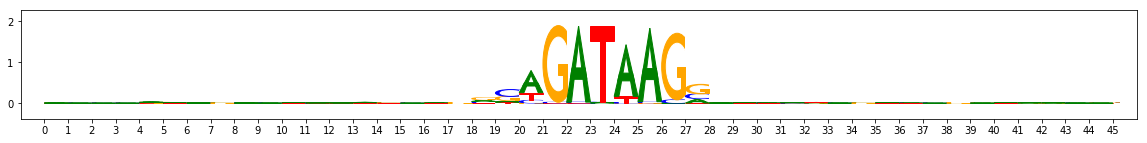

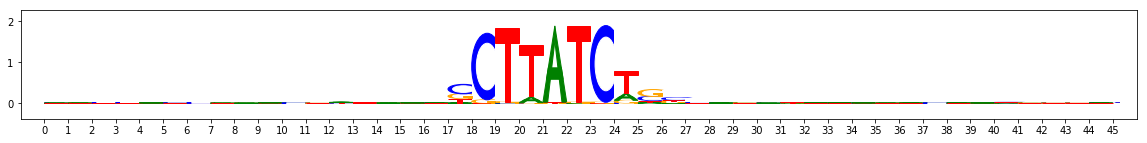

metacluster_2
activity pattern: [0 1 0]
metacluster_2 pattern_0
total seqlets: 124
Task 0 hypothetical scores:


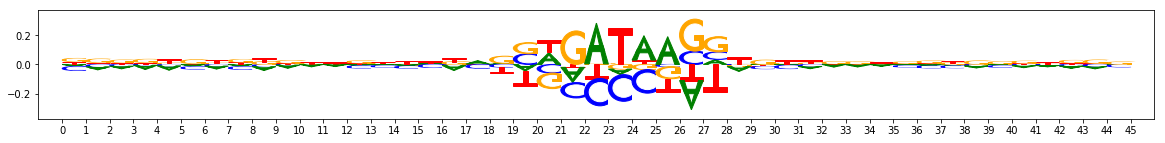

Task 0 actual importance scores:


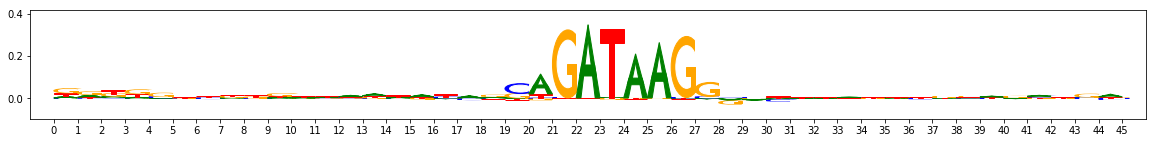

Task 1 hypothetical scores:


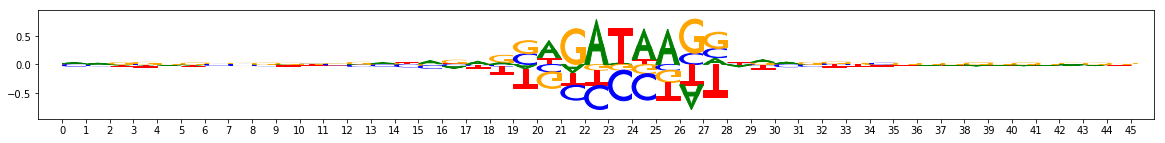

Task 1 actual importance scores:


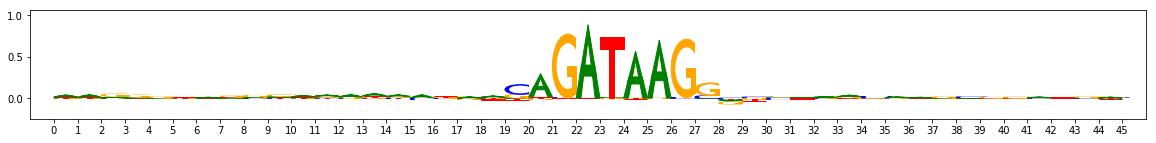

Task 2 hypothetical scores:


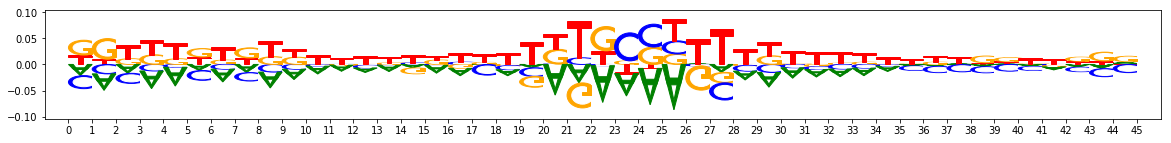

Task 2 actual importance scores:


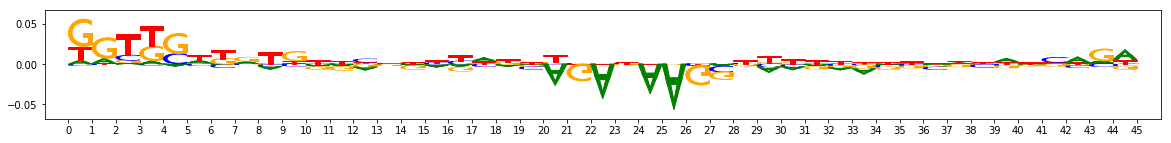

onehot, fwd and rev:


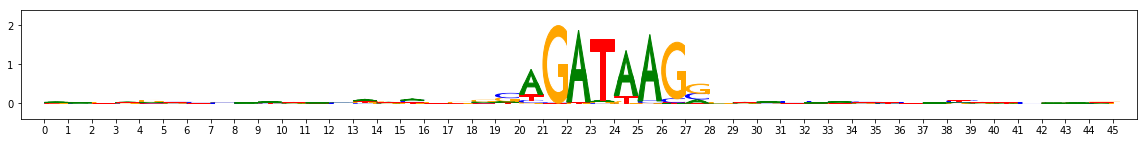

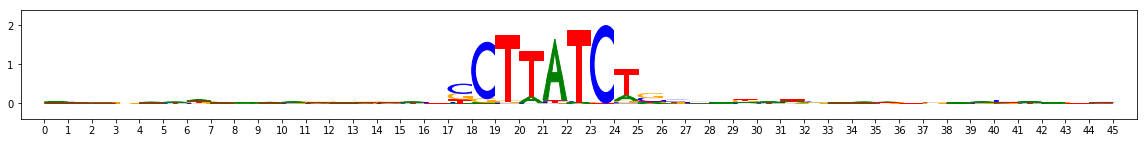

metacluster_3
activity pattern: [0 0 1]
metacluster_3 pattern_0
total seqlets: 97
Task 0 hypothetical scores:


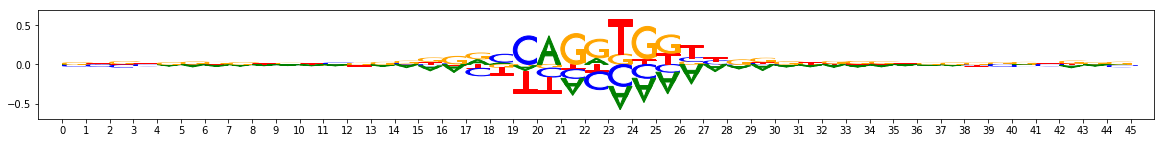

Task 0 actual importance scores:


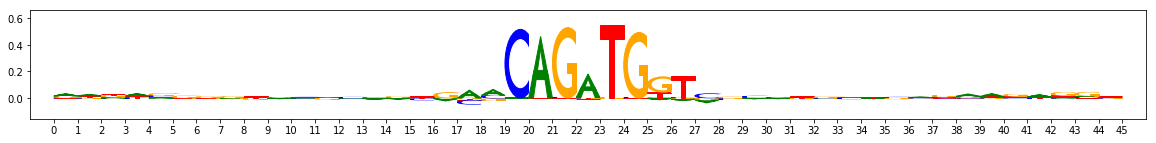

Task 1 hypothetical scores:


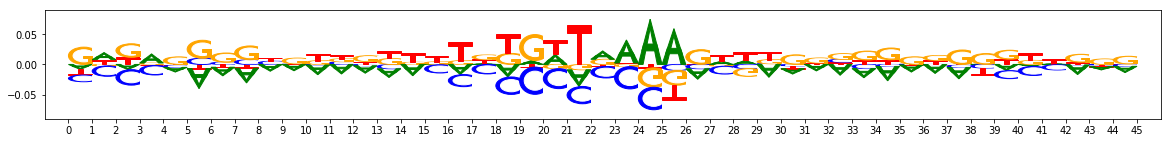

Task 1 actual importance scores:


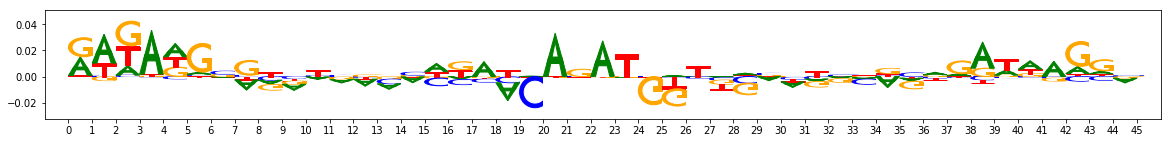

Task 2 hypothetical scores:


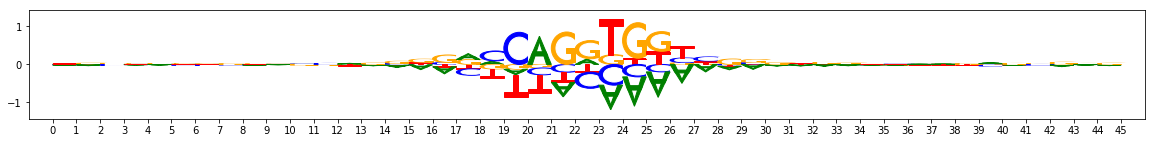

Task 2 actual importance scores:


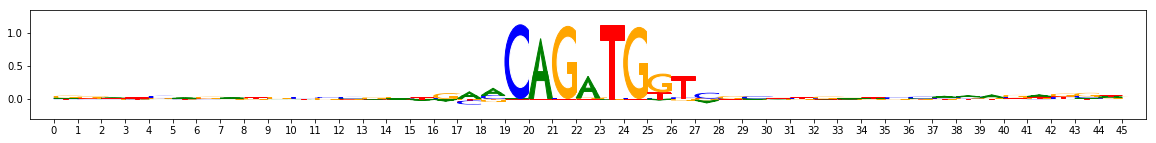

onehot, fwd and rev:


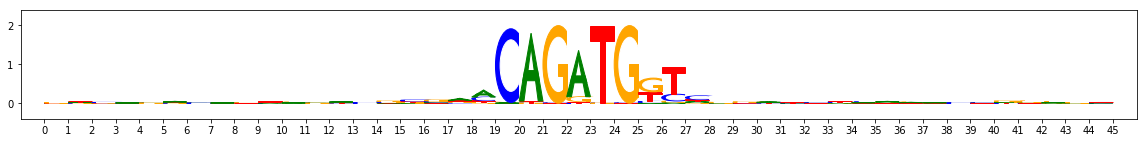

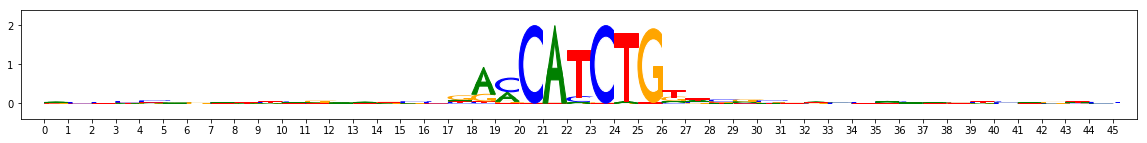

In [9]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Investigate co-enrichment of motifs

TF-MoDISco identified the following motifs:
- "metacluster_0, pattern_0" is the TAL motif (CAGATG) with high importance for both task 0 and task 2
- "metacluster_3, pattern_0" is the TAL motif (CAGATG) with high importance only for task 2
- "metacluster_1, pattern_0" is the GATA motif (GATAAG) with high importance for both task 0 and task 1
- "metacluster_2, pattern_0" is the GATA motif (GATAAG) with high importance only for task 1

In the underlying simulation, a 1 for task 0 requires the presence of both the TAL motif (CAGATG) and the GATA motif (GATAAG). This is reflected in the co-enrichment patterns. We find that:
- "metacluster_0, pattern_0" (TAL motif that is high for task 0) co-occurs with "metacluster_1, pattern_0" (GATA motif that is high for task 0) more than "metacluster_2, pattern_0" (GATA motif that is not high for task 0).
- "metacluster_1, pattern_0" (GATA motif that is high for task 0) co-occurs  with "metacluster_0, pattern_0" (TAL motif that is high for task 0) more than "metacluster_3, pattern_0" (TAL motif that is not high for task 0), although the difference is not statistically significant with these sample sizes

The code to compute this is below:

In [11]:
import scipy.stats
import h5py

hdf5_results = h5py.File("results.hdf5","r")

patterns_to_compare = [
    [("metacluster_1", "pattern_0"), ("metacluster_2", "pattern_0")],
    [("metacluster_0", "pattern_0"), ("metacluster_3", "pattern_0")]
]

for ((pattern1_metacluster, pattern1_name),
     (pattern2_metacluster, pattern2_name)) in patterns_to_compare:
    
    print("Comparing "+pattern1_metacluster+"_"+pattern1_name
          +" and "+pattern2_metacluster+"_"+pattern2_name)
    
    pattern1_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                             [pattern1_metacluster]["seqlets_to_patterns_result"]\
                                             ["patterns"][pattern1_name]["seqlets_and_alnmts"]["seqlets"])
    pattern1_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern1_seqlets])

    pattern2_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                         [pattern2_metacluster]["seqlets_to_patterns_result"]\
                                         ["patterns"][pattern2_name]["seqlets_and_alnmts"]["seqlets"])
    pattern2_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern2_seqlets])

    for (comparison_pattern_metacluster,
         comparison_pattern_name) in all_patterns:
        
        if ((comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern1_metacluster+"_"+pattern1_name)
            and (comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern2_metacluster+"_"+pattern2_name)):
            
            comparison_pattern_seqlets = list(
                hdf5_results["metacluster_idx_to_submetacluster_results"]\
                [comparison_pattern_metacluster]["seqlets_to_patterns_result"]\
                ["patterns"][comparison_pattern_name]["seqlets_and_alnmts"]["seqlets"])
            comparison_pattern_example_idxs = set([
                x.decode("utf-8").split(",")[0].split(":")[1] for x in
                comparison_pattern_seqlets])
        
            
            pattern1_overlap = len(pattern1_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            pattern2_overlap = len(pattern2_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            
            contingency_table = np.array([
                [pattern1_overlap, len(pattern1_example_idxs)-pattern1_overlap],
                [pattern2_overlap, len(pattern2_example_idxs)-pattern2_overlap]])
            odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
            if (p_value < 0.25):
                print("Looking at enrichment for "+comparison_pattern_metacluster
                                              +"_"+comparison_pattern_name)
                print("Odds ratio:",odds_ratio,
                      "P-value:",p_value)

            
hdf5_results.close()

Comparing metacluster_1_pattern_0 and metacluster_2_pattern_0
Looking at enrichment for metacluster_0_pattern_0
Odds ratio: 1.558139534883721 P-value: 0.04989907768135691
Comparing metacluster_0_pattern_0 and metacluster_3_pattern_0
Looking at enrichment for metacluster_1_pattern_0
Odds ratio: 1.5016592920353982 P-value: 0.10245334859576313
